# Demo: Fundamentals, GDAL, rasterio Discussion

# Introduction

## What is a raster?

## Raster data sources
* Satellite imagery
* Gridded model output
* Interpolated vector data

# Raster fundamentals (interactive discussion)

### Dimensions (width [columns] and height [rows] in pixels)
### CRS (coordinate system)
### Extent (bounds)
### Resolution (pixel size)
### Data type (bit depth)
### Number of bands
### NoData values
* NumPy masked arrays vs. float/np.nan
### Overviews

## GDAL (Geospatial Data Abstraction Library) and Rasterio
GDAL is a powerful and mature library for reading, writing and warping raster datasets, written in C++ with bindings to other languages. There are a variety of geospatial libraries available on the python package index, and almost all of them depend on GDAL. One such python library developed and supported by Mapbox, rasterio, builds on top of GDAL’s many features, but provides a more pythonic interface and supports many of the features and formats that GDAL supports. Both GDAL and rasterio are constantly being updated and improved.

## Raster formats
* GeoTiff is most common
* GDAL is the foundation

## Projections
* Most often UTM
* PROJ is the foundation

## Raster transformations
* Need a way to go from pixel coordinates (image on your screen) to real-world coordinates (projected)
    * Pixel coordinates: image width, height in units of pixels, starting at (0,0)
    * Real-world coordiantes: projected coordinate system (e.g., UTM 10N), units of meters
* Origin is usually upper left corner of upper left pixel
    * Careful about this - you will definitely run into this problem at some point
    * Often your grid may be shifted by a half a pixel in x and y
* Negative y cell size - what's up with that?

### GDAL/ESRI affine

### rasterio affine
* Multiply affine by raster indices to get projected coordinates
* Rasterio dataset `xy` and `index` methods

## Basic raster structure
* Dataset
* Bands
* Read band to get underlying 2D array data

## 3D array to create composites from multispectral bands
* Can dstack 2D arrays

## Misc
* Be careful with large rasters
* Try to avoid creating many copies of arrays

## GDAL command line utilities

* Learn these: https://gdal.org/programs/index.html
    * gdalinfo
    * gdal_translate
    * gdalwarp
    * gdaladdo
* Items to discuss
    * Use standard creation options (co)
        * TILED=YES
        * COMPRESS=LZW
        * BIGTIFF=IF_SAFER
    * Resampling algorithms
        * Default is nearest
        * Often bilinear or bicubic is a better choice for reprojecting, upsampling, downsampling

https://medium.com/planet-stories/a-gentle-introduction-to-gdal-part-4-working-with-satellite-data-d3835b5e2971

# Demo

https://automating-gis-processes.github.io/site/notebooks/Raster/reading-raster.html

In [1]:
import os
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Create local directory to store images
imgdir = 'LS8_sample'
#Winter 2018
img_id1 = 'LC08_L1TP_046027_20181224_20190129_01_T1'
#Summer 2018
img_id2 = 'LC08_L1TP_046027_20180818_20180829_01_T1'
img = img_id2

In [3]:
sample_fn = os.path.join(imgdir, img+'_B1.TIF')
print(sample_fn)

LS8_sample/LC08_L1TP_046027_20180818_20180829_01_T1_B1.TIF


In [4]:
!gdalinfo $sample_fn

Driver: GTiff/GeoTIFF
Files: LS8_sample/LC08_L1TP_046027_20180818_20180829_01_T1_B1.TIF
Size is 7781, 7881
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 10N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 10N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-123,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre",1

In [5]:
#Specify filenames for different bands we will need for the lab
#Check table from background section to see wavelengths of each band number
tir_fn = os.path.join(imgdir, img+'_B10.TIF')
print(tir_fn)

LS8_sample/LC08_L1TP_046027_20180818_20180829_01_T1_B10.TIF


In [6]:
with rio.open(tir_fn) as src:
    print(src.profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7781, 'height': 7881, 'count': 1, 'crs': CRS.from_epsg(32610), 'transform': Affine(30.0, 0.0, 473385.0,
       0.0, -30.0, 5373315.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


In [7]:
src = rio.open(tir_fn)

In [8]:
type(src)

rasterio.io.DatasetReader

In [9]:
src.profile

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7781, 'height': 7881, 'count': 1, 'crs': CRS.from_epsg(32610), 'transform': Affine(30.0, 0.0, 473385.0,
       0.0, -30.0, 5373315.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

In [10]:
src.read?

Docstring:
Read a dataset's raw pixels as an N-d array

This data is read from the dataset's band cache, which means
that repeated reads of the same windows may avoid I/O.

Parameters
----------
indexes : list of ints or a single int, optional
    If `indexes` is a list, the result is a 3D array, but is
    a 2D array if it is a band index number.

out : numpy ndarray, optional
    As with Numpy ufuncs, this is an optional reference to an
    output array into which data will be placed. If the height
    and width of `out` differ from that of the specified
    window (see below), the raster image will be decimated or
    replicated using the specified resampling method (also see
    below).

    *Note*: the method's return value may be a view on this
    array. In other words, `out` is likely to be an
    incomplete representation of the method's results.

    This parameter cannot be combined with `out_shape`.

out_dtype : str or numpy dtype
    The desired output data type. For examp

In [11]:
%time
a = src.read(1)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.48 µs


In [12]:
a

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [13]:
a.shape

(7881, 7781)

In [14]:
a.size

61322061

In [15]:
a.max()

65535

In [16]:
a

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [17]:
#%matplotlib widget

In [18]:
src.bounds

BoundingBox(left=473385.0, bottom=5136885.0, right=706815.0, top=5373315.0)

In [19]:
full_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

In [20]:
full_extent

[473385.0, 706815.0, 5136885.0, 5373315.0]

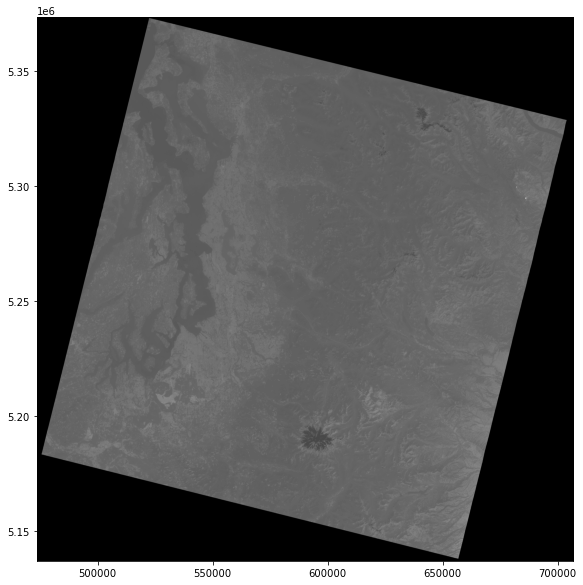

In [21]:
f, ax = plt.subplots(figsize=(10,10))
ax.imshow(a, cmap='gray', extent=full_extent)

## Image bit depth
Number of possible intensity values

In [22]:
2**12

4096

In [23]:
2**8


256

In [24]:
2**16

65536